In [1]:
from typing import Annotated, List, Dict, Any
from typing_extensions import TypedDict
from langgraph.graph import START, END, StateGraph
from langgraph.graph.message import add_messages
from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver

In [2]:
class State(TypedDict):
    messages: Annotated[List, add_messages]

In [4]:
def route(state: State) -> str:
    last_message = state['messages'][-1].content.lower()
    if any(word in last_message for word in ["reset", "clear memory", "clear", "start over", "forget"]):
        return "reset"
    return "chat"

In [5]:
llm = ChatOpenAI(model="gpt-4o-mini")

In [6]:
def chat_node(state: State) -> Dict[str, Any]:
    messages = state["messages"]
    chat = llm.invoke(messages)
    return {"messages": [chat]}

In [10]:
def reset_node(state: State) -> Dict[str, Any]:
    return {"messages": [AIMessage(content="Memory Reset!")]}

In [17]:
graph = StateGraph(State)
graph.add_node("chatbot", chat_node)
graph.add_node("reset", reset_node)

graph.add_conditional_edges(
    START,
    route,
    {
        "chat": "chatbot", "reset": "reset"
    }
)
graph.add_edge("chatbot", END)
graph.add_edge("reset", END)
MEMORY = MemorySaver()

app = graph.compile(checkpointer=MEMORY)

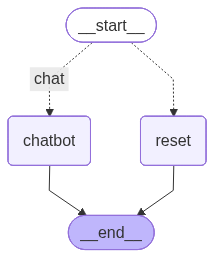

In [18]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [23]:
def test(user_input, thread_id):
    config = {"configurable": {"thread_id": thread_id}}
    state: State = {
        "messages": [HumanMessage(content=user_input)]
    }
    state = app.invoke(state, config=config)
    for m in state['messages']:
        print(m.__class__.__name__, ":", m.content)


In [24]:
test("Hi I'm Manmath", "demo-001")

HumanMessage : Hi I'm Manmath
AIMessage : Hi Manmath! How can I assist you today?


In [25]:
test('forget', 'demo-001')

HumanMessage : Hi I'm Manmath
AIMessage : Hi Manmath! How can I assist you today?
HumanMessage : forget
AIMessage : Memory Reset!
